# Demo for using CEBRA on the outputs of DeepLabCut

- CEBRA is not solely for neural data analysis, and can be used on any time-series data (or single time points, but it's strength is in time-series analysis).
- This notebook outlines the use of [DeepLabCut](https://www.mackenziemathislab.org/deeplabcut) outputs for behavioral clustering.
- The demo data used here is from [AmadeusGPT](https://www.mackenziemathislab.org/amadeusgpt), our large langugage model agentic system for behavioral analysis, which also supports DeepLabCut and CEBRA!

**This Notebook shows you how to use the self-supervised variant of CEBRA for 2D and 3D embeddings!**

In [ ]:
!pip install --pre 'cebra[datasets,integrations]'

- please restart session (click button ⬆️)

## Import the package and define an unsupervised CEBRA model

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

#for model saving:
import os
import tempfile
from pathlib import Path

In [3]:
# 1. Define a CEBRA models
# we will do 2D and 4D

cebra_model2D = CEBRA(
    model_architecture="offset10-model-mse", #consider: "offset10-model-mse" if Euclidean
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    max_iterations=500, # start with default
    conditional='time', #for supervised, put 'time_delta', or 'delta'
    output_dimension=2,
    distance='euclidean', #consider 'euclidean'; if you set this, output_dimension min=2
    device="cuda_if_available",
    verbose=True,
    time_offsets=10
)

cebra_model4D = CEBRA(
    model_architecture="offset10-model", #consider: this will use the n-sphere embedding
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    max_iterations=500, # start with default
    conditional='time', #for supervised, put 'time_delta', or 'delta'
    output_dimension=4,
    distance='cosine',
    device="cuda_if_available",
    verbose=True,
    time_offsets=10
)

## Grab DeepLabCut demo data
- this is the `.h5` file that you get after video analysis. This is demo data used within [AmadeusGPT](https://github.com/AdaptiveMotorControlLab/AmadeusGPT/blob/main/examples/EPM/EPM_11DLC_snapshot-1000.h5)

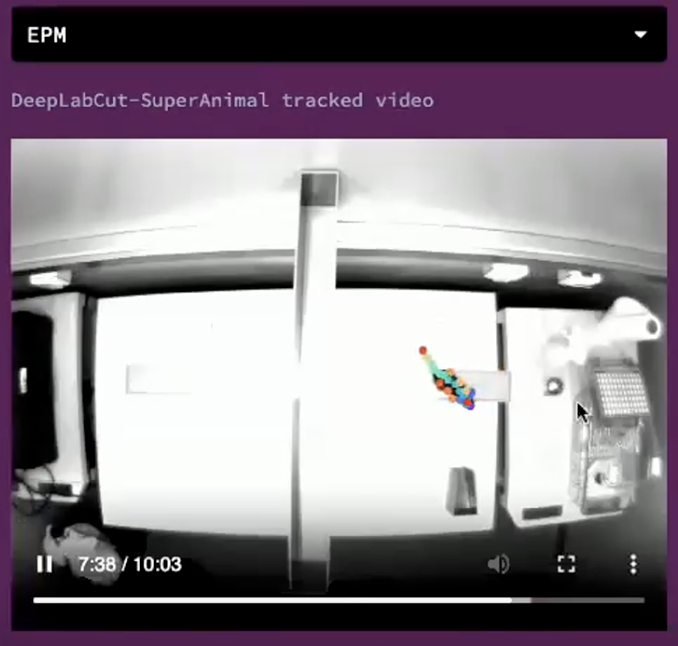

In [4]:
# 2. Fetch and then load the data
! curl -L -O https://github.com/AdaptiveMotorControlLab/AmadeusGPT/raw/main/examples/EPM/EPM_11DLC_snapshot-1000.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9700k  100 9700k    0     0  6548k      0  0:00:01  0:00:01 --:--:-- 11.6M


In [5]:
import h5py
f = h5py.File('EPM_11DLC_snapshot-1000.h5', 'r')
list(f.keys())  # inspect top-level keys


['df_with_missing']

### This is the built in DLC loader for 🦓 CEBRA!

In [6]:
dlc_data = cebra.load_deeplabcut('./EPM_11DLC_snapshot-1000.h5', pcutoff = 0.6)

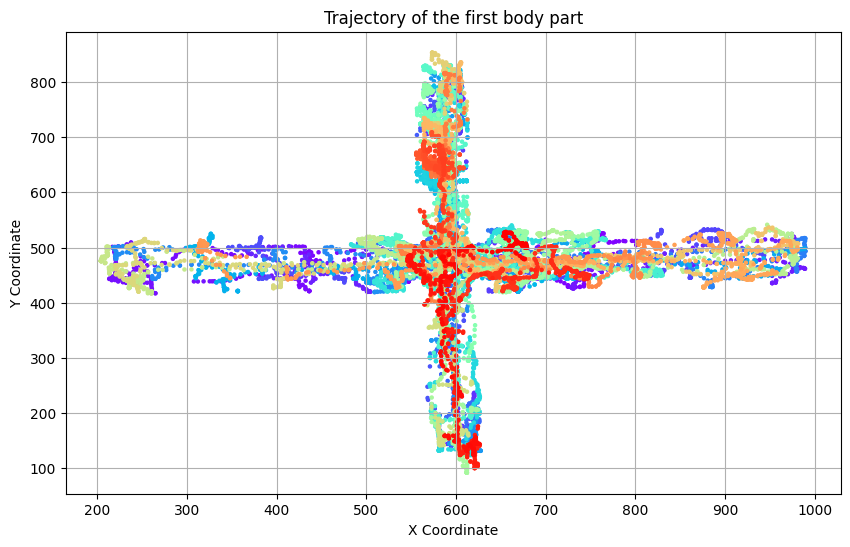

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(dlc_data[:, 0], dlc_data[:, 1], c=np.arange(len(dlc_data)), cmap='rainbow', s=5)
plt.title('Trajectory of the first body part')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

## Now that the data is loaded and checked, let's use CEBRA!

In [8]:
# 3. Train and transform your model!
 # fit
cebra_time_full_model2D = cebra_model2D.fit(dlc_data)
cebra_time_full_model4D = cebra_model4D.fit(dlc_data)
# transform
cebra_time_full2D = cebra_model2D.transform(dlc_data)
cebra_time_full4D = cebra_model4D.transform(dlc_data)

pos:  1.0293 neg:  2.6415 total:  3.6708 temperature:  1.1200: 100%|██████████| 500/500 [00:09<00:00, 50.92it/s] 
pos: -0.8511 neg:  6.3554 total:  5.5043 temperature:  1.1200: 100%|██████████| 500/500 [00:08<00:00, 59.02it/s]


## Let's check the loss curve, examine the goodness of fit, then visualize the embedding


100%|██████████| 500/500 [00:02<00:00, 229.79it/s]


 GoF in bits - full 2D: 3.5434484345827015
 GoF in bits - full 4D: 1.0726874258913286


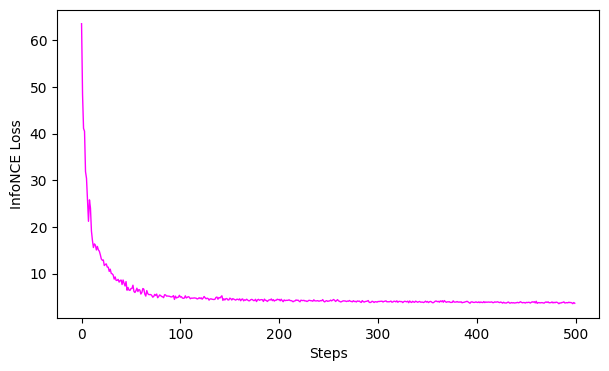

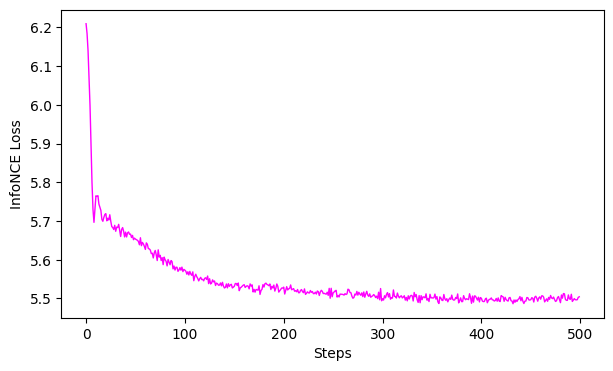

In [9]:
# 4. Evaluation
# GoFs
gof_full2D = cebra.sklearn.metrics.goodness_of_fit_score(cebra_time_full_model2D, dlc_data)
gof_full4D = cebra.sklearn.metrics.goodness_of_fit_score(cebra_time_full_model4D, dlc_data)
print(" GoF in bits - full 2D:", gof_full2D)
print(" GoF in bits - full 4D:", gof_full4D)
# plot the loss curves
ax = cebra.plot_loss(cebra_time_full_model2D)
ax = cebra.plot_loss(cebra_time_full_model4D)

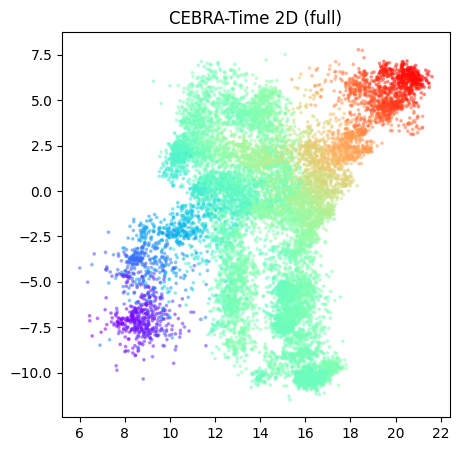

In [10]:
# 5. Visulization, 2D model:
fig = cebra.plot_embedding(cebra_time_full2D, embedding_labels=dlc_data[:,0],title = "CEBRA-Time 2D (full)", markersize=3, cmap = "rainbow")


In [11]:
# 5. Visulization, 3D+ model:

# plot embedding for outdim =>3:
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_time_full4D,
                                                           embedding_labels=dlc_data[:,0],
                                                           title = "CEBRA-Time (full)",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show(renderer="notebook")

<Figure size 500x500 with 0 Axes>

### Save the models 🦓

In [12]:
tmp_file2D = Path(tempfile.gettempdir(), 'cebra2D.pt')
tmp_file4D = Path(tempfile.gettempdir(), 'cebra4D.pt')
cebra_model2D.save(tmp_file2D)
cebra_model2D.save(tmp_file4D)
#reload one to check ✅
cebra_model = cebra.CEBRA.load(tmp_file2D)

### 🚧 To see the full range of options, including how to pick best parameters, please see the ["Best practices"](https://cebra.ai/docs/demo_notebooks/CEBRA_best_practices.html) notebook!

Enjoy!